# Stochastic T-cell activation Model

Version: latsim03_edit_freely \
[master version](https://colab.research.google.com/drive/1cs49PDxbP_Ac83jh84h4xfowCZYF6SbN?usp=sharing)

Created by: Neil H Kim\
Last updated: 2022.10.9


<img src="https://i.imgur.com/MAJZywf.png" width="700">  
\
<img src="https://i.imgur.com/SsFsMJI.png" width="700">




* Use policy \\
. Any Groves Lab person can comment/edit this notebook. \\
. The unedited stable version is stored in my [github repository](https://github.com/neilhkim/LATsim01).



### <-- Click ▼ to collapse the initialization code

In [ ]:
# Import necessary libraries and models
import random
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import itertools
from ipywidgets import IntProgress
from IPython.display import display
import sys
from math import exp

# Uncomment the following lines if using Google Colab to mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Set matplotlib parameters for consistent plot appearance
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 2

def propensity(inputstr, t=0):
    """Evaluate a propensity function string as a Python expression."""
    a = 0  # Initialize the result variable
    try:
        a = eval(inputstr)  # Evaluate the input string as a Python expression
    except:
        print('propensity function string not interpretable.')  # Print error message if evaluation fails
    return a  # Return the evaluated result

def plot_propensity_fn(inputstr):
    """Plot a propensity function string as a Python expression.
    The input string should be a valid Python expression that can be evaluated by the eval() function
    and should include the variable t as the independent variable.
    
    Args:
        inputstr (str): The input string representing the propensity function.

    Returns:
        matplotlib.axes._axes.Axes: The plot of the propensity function.
    """
    timespan = np.linspace(0, 100, 100)
    y = [propensity(inputstr, t) for t in timespan]
    fig = plt.figure(figsize=(5,3)) # The unit is inches
    ax = fig.add_axes([0.2, 0.2, 0.6, .6]) # This unit is percentage
    ax.plot(timespan, y, color='cornflowerblue', label=inputstr, linewidth=3)
    ax.set_title('User input propensity function', fontsize=14,)
    ax.set_xlabel(r'Time (s)', labelpad=10)
    ax.set_ylabel(r'Propensity', labelpad=10)
    ax.legend(frameon=False, fontsize=9, loc='upper right')
    return ax

def calculate_rates(pmhc_lifetimes, kbind, kunbind, propensity_fn_str):
    """Calculate the reaction rates for the Gillespie algorithm.
    
    Args:
        pmhc_lifetimes (numpy.ndarray): Array of pMHC lifetimes.
        kbind (float): Binding rate constant.
        kunbind (float): Unbinding rate constant.
        propensity_fn_str (str): Propensity function string.

    Returns:
        numpy.ndarray: Array of reaction rates.
    """
    # Three possible reactions - 0: new pMHC binds, 1: bound pMHC unbinds, 2: bound pMHC forms LAT
    n_pmhc = pmhc_lifetimes.size
    rates = np.array([kbind, kunbind * n_pmhc]) # Rate 0 and Rate 1
    if pmhc_lifetimes.size > 0: # adding Rate 2 (per each bound pMHC)
        for t in np.nditer(pmhc_lifetimes):
            rates = np.append(rates, propensity(propensity_fn_str, t))
    return rates

def draw_rxnidx(probs):
    """Draw a reaction index based on the probabilities of each reaction for deciding which reaction to occur in the Gillespie algorithm.
    Args:
        probs (numpy.ndarray): Array of reaction probabilities.
        
    Returns:
        int: The index of the drawn reaction.
    """
    q = np.random.rand()
    # Randonly draw rxn index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1 

def gillespie_draw(pmhc_lifetimes, kb, kub, propensity_fn_str):
    """Draw the next reaction and time step for the Gillespie algorithm.
    
    Args:
        pmhc_lifetimes (numpy.ndarray): Array of pMHC lifetimes.
        kb (float): Binding rate constant.
        kub (float): Unbinding rate constant.
        propensity_fn_str (str): Propensity function string.
        
    Returns:
        int: The index of the drawn reaction.
        float: The time step for the next reaction.
    """
    rates = calculate_rates(pmhc_lifetimes, kb, kub, propensity_fn_str)
    rate_sum = rates.sum()
    t_next = np.random.exponential(1.0 / rate_sum)
    rxn_probs = rates / rate_sum
    rxnidx = draw_rxnidx(rxn_probs)
    return rxnidx, t_next

def gillespie_ssa(kb, kub, propensity_fn_str, time_points, huge_nlat_earlyfinish_zeroifnot_used,):
    """ Perform a Gillespie simulation for a single cell.
    
    Args:
        kb (float): Binding rate constant.
        kub (float): Unbinding rate constant.
        propensity_fn_str (str): Propensity function string.
        time_points (numpy.ndarray): Array of time points.
        huge_nlat_earlyfinish_zeroifnot_used (int): The number of LAT condensates at which to end the simulation early.
        
    Returns:
        numpy.ndarray: Array of time points and species counts.
        numpy.ndarray: Array of pMHC lifetimes.
        int: The number of LAT condensates formed.

    Note: The function returns the time record, pMHC lifelog, and the number of LAT condensates formed.
        pMHC lifelog is a 2D array where each row corresponds to a pMHC molecule and each column corresponds to a time point.
        (Examples): 
            - pMHC lifetime (non-productive life) : [0, 0, 0, 0, 0, 0, np.nan, np.nan, ..., np.nan] : bound (0) -> unbound (nan)
            - pMHC lifetime (productive life)     : [0, 0, 1, 1, 1, 1,  np.nan, np.nan, ... np.nan] : bound (0) -> produce LAT condensate (1) -> unbound (nan)
    """
    # Initialize output
    n_species = 3
    time_record = np.empty((len(time_points), n_species), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    n_timepoints = time_points.size
    pmhc_lifelog = np.array([])
    '''    (Examples)
    pmhc_lifelog[i] (non-productive life) : [0, 0, 0, 0, 0, 0, np.nan, np.nan, ..., np.nan] : bound (0) -> unbound (nan)
    pmhc_lifelog[j] (producctive life)    : [0, 0, 1, 1, 1, 1,  np.nan, np.nan, ... np.nan] : bound (0) -> produce LAT condensate (1) -> unbound (nan)
    '''
    pmhc_lifetimes = np.array([]).reshape((-1,2)) # [index, lifetime]
    remaining_latlifetimes = np.array([]).reshape((-1,2)) # [index, lifetime]
    n_pmhc = n_lat = pmhc_number = lat_index = int(0)
    
    # Initialize time record
    time_record[0,:] = np.array([0] * n_species) # [n_pmhc, n_lat, plat_level(0-1)]
    # Initialize pmhc_ids and latmaking_pmhcids
    pmhc_ids = latmaking_pmhcids = []

    # Initialize plat_level
    plat_level = int(0)

    # Run while loop until the it reaches the end of simulation timepoints.
    while i < len(time_points):

        # While loop to simulate the time evolution of the system until the next time point.
        while t < time_points[i_time]:

            # Save the previous record
            previous_record = np.array([n_pmhc, n_lat, plat_level])
            # Draw the next event and time step
            event, dt = gillespie_draw(pmhc_lifetimes[:,1], kb, kub, propensity_fn_str) # event number also indicates the index of the pMhc that results in LAT condensation. 

            # Increment time
            pmhc_lifetimes[:,1] += dt
            
            # Update plat_level
            plat_level -= dt * plat_level * 0.05 # arbitrary phosphatase strength (as compared to kinase strength)
            plat_level += len(pmhc_ids) * dt * 1 # set kinase strength as 1.
            
            # Update remaining_latlifetimes
            remaining_latlifetimes[:,1] -= dt
            # Remove negative values from remaining_latlifetimes
            subzero_idx = np.argwhere(remaining_latlifetimes[:,1] < 0)
            remaining_latlifetimes = np.delete(remaining_latlifetimes, subzero_idx, axis=0) 
            
            # Update time
            t += dt

            # Process which event happened.
            if event == 0: # new binding
                pmhc_lifetimes = np.append(pmhc_lifetimes, [pmhc_number, 0])
                pmhc_lifetimes = np.reshape(pmhc_lifetimes, (-1,2))
                entry = np.empty(n_timepoints)
                entry[:] = np.nan # Later, np.nan will be an indicator of log at yet to approach timepoints
                entry[0] = 0
                pmhc_lifelog = np.append(pmhc_lifelog, entry)
                pmhc_lifelog = np.reshape(pmhc_lifelog, (-1,n_timepoints))
                pmhc_ids.append(int(pmhc_number))
                pmhc_number += 1
            elif event == 1: # unbinding
                random_index = random.randrange(len(pmhc_ids))
                popped_pmhcindex = int(pmhc_ids.pop(random_index))
                i = np.argwhere(pmhc_lifetimes[:,0] == popped_pmhcindex)
                pmhc_lifetimes = np.delete(pmhc_lifetimes, i, 0)                    
            else: # LAT condensation
                alpha, scale = 1.78, 1/0.0592 # experimentally determined values
                lifelength = np.random.gamma(alpha, scale)
                addarray = np.array([lat_index, lifelength])
                remaining_latlifetimes = np.append(remaining_latlifetimes, addarray).reshape((-1,2))
                lat_index += 1
                latmaking_pmhc_no = event - 2  # event number 2, 3, ... means LAT condensate producing pMHC's index is 0, 1, ...
                latmaking_pmhcids.append(int(pmhc_lifetimes[latmaking_pmhc_no,0]))
                pmhc_lifetimes = np.delete(pmhc_lifetimes, latmaking_pmhc_no, axis=0) 
            
            # Update the number of pMHCs and LAT condensates
            n_pmhc = len(pmhc_ids)
            n_lat = len(remaining_latlifetimes)

        # Update the index
        i = np.searchsorted(time_points > t, True)
        # Fill time record until this change occurred
        time_record[i_time:min(i,len(time_points))] = previous_record

        # Check if the simulation should end early
        if n_lat >= huge_nlat_earlyfinish_zeroifnot_used > 0:
            time_record[i:len(time_points)] = previous_record
            break # If the number of LAT condensates exceeds the threshold, end the simulation early

        # Classify the pMHCs into groups
        yet_unproductive_pmhcs = [item for item in pmhc_ids if item not in latmaking_pmhcids]
        productive_stillbound_pmhcs = [item for item in pmhc_ids if item in latmaking_pmhcids]
        yet_unproductive_pmhcs = [int(x) for x in yet_unproductive_pmhcs]
        productive_stillbound_pmhcs = [int(x) for x in productive_stillbound_pmhcs]

        # Update pmhc_lifelog based on the classification
        for x in yet_unproductive_pmhcs: # If the pMHC is not yet productive, fill the log with 0
            pos = np.where(np.isnan(pmhc_lifelog[x]))[0]
            if len(pos):
                earlist_nan_position = pos[0]
                pmhc_lifelog[x,earlist_nan_position:earlist_nan_position+i-i_time] = int(0)

        for x in productive_stillbound_pmhcs: # If the pMHC is productive and still bound, fill the log with 1
            pos = np.where(np.isnan(pmhc_lifelog[x]))[0]
            if len(pos):
                earlist_nan_position = pos[0]
                pmhc_lifelog[x,earlist_nan_position:earlist_nan_position+i-i_time] = int(1)

        # Increment index
        i_time = i
  
    return time_record, pmhc_lifelog, lat_index

def cell_activation_prob(x, ec50):
    """ Calculate the probability of cell activation based on the number of LAT condensates.
    
    Args:
        x (int): The number of LAT condensates.
        ec50 (int): The EC50 value of LAT condensates for cell activation.
        
    Returns:
        float: The probability of cell activation.
    """
    # Experimentally fitted curve: x^4.28/(x^4.28 + 3^4.28)
    K = 4.28
    return x ** K / (x ** K + ec50 ** K) # If x = 15, ret-value is .999

def run( # default values are provided as examples 
    kunbind_list = [0.11], # Following the known kunbind of MCC, which are is 0.042/s and T102S is 0.11/s
    ligand_densities = [.7], # Typical ligand densities of 0.7/um2
    n_experiment_per_ligdensity = 1, 
    lat_formation_propensity_fn_str = '0', 
    plot_lat_propensity = False, 
    n_cell = 1, 
    endtime = 120, # 120 is a reasonable end time for the simulation
    n_timepoints = 100,  # 100 is a reasonable number of time points for the simulation
    huge_nlat_earlyfinish_zeroifnot_used=0, 
    ec50_cellactivating_nlat = 3, 
    plot_time_traces = False, 
    plot_activation_titration_curve = False, 
    display_progressbar = False, 
    outfname_ifnotnull_write = '', 
    early_assume_100p = False, 
    hypothetical_EC50_platlevel_zeroifnot_used = 0, # Not in use.
    hypothetical_EC50_totalnlat_zeroifnot_used = 0, # Not in use.
    ):
    """ Run the simulation with the given parameters.
    
    Args:
        kunbind_list (list): List of unbinding rate constants.
        ligand_densities (list): List of ligand densities.
        n_experiment_per_ligdensity (int or list): Number of experiments per ligand density.
        lat_formation_propensity_fn_str (str): Propensity function string.
        plot_lat_propensity (bool): Plot the propensity function.
        n_cell (int): Number of cells.
        endtime (int): End time of the simulation.
        n_timepoints (int): Number of time points.
        huge_nlat_earlyfinish_zeroifnot_used (int): Number of LAT condensates at which to end the simulation early and assume activation.
        ec50_cellactivating_nlat (int): EC50 value for cell activation based on the maximum number of LAT condensates during the simlation.
        plot_time_traces (bool): Plot the time traces.
        plot_activation_titration_curve (bool): Plot the activation titration curve.
        display_progressbar (bool): Display the progress bar.
        outfname_ifnotnull_write (str): Output file name.
        early_assume_100p (bool): If True, assume 100% activation for the current ligand density if the previous ligand density resulted in 100% activation.
        hypothetical_EC50_platlevel_zeroifnot_used (int): Hypothetical EC50 value for cell activation based on the maximum phosphorylated LAT molecule level during the simulation. 
        hypothetical_EC50_totalnlat_zeroifnot_used (int): Hypothetical EC50 value for cell activation based on the cumulative number of all LAT molecules created by the T-cell during the simulation.
        
    Returns:
        None
    """

    # If n_experiment_per_ligdensity was passed as type integer, make it a list of the integer with length matching len(ligand_densities)
    if type(n_experiment_per_ligdensity) == int:
        n_experiment_per_ligdensity = [n_experiment_per_ligdensity] * len(ligand_densities)

    # Check if the number of ligand densities and the number of n_experiment_per_ligdensity match
    if len(ligand_densities) != len(n_experiment_per_ligdensity):
        sys.exit('The number of ligand densities and the number of n_experiment_per_ligdensity do not match')

    # Plot the propensity function if plot_lat_propensity is True
    if plot_lat_propensity:
        ax_p = plot_propensity_fn(lat_formation_propensity_fn_str)
        ax_p.set_title('User input LAT formation propensity function', fontsize=14,)
        plt.tight_layout()
        if outfname_ifnotnull_write != '':
            plt.savefig(outfname_ifnotnull_write + '_propensity.png')
            plt.savefig(outfname_ifnotnull_write + '_propensity.svg')
        plt.show(block=False)
    
    # Seed random number generator for reproducibility
    np.random.seed(51) 
    
    # Initialize the time points
    time_points = np.linspace(0, endtime, n_timepoints)

    # Set the ligand density to kbind factor
    LIGAND_DENSITY_TO_KBIND_FACTOR = 1.3 # This value was measured by Darren and Mark. 
    # kbind_list = [ld * LIGAND_DENSITY_TO_KBIND_FACTOR for ld in ligand_densities]
    
    # Initialize the output dataframe
    df = pd.DataFrame(columns = ['kunbind', 'kbind', 'ligand_density', 'prob_activate', 'n_cell'])

    # Loop over the unbinding rate constants
    for kunbind in kunbind_list:
        print(f'--- kunbind  {kunbind}')
        assume_100p = False
        for density_idx in range(len(ligand_densities)):
            # Calculate the binding rate constant
            kbind = ligand_densities[density_idx] * LIGAND_DENSITY_TO_KBIND_FACTOR

            # Initialize output array
            n_experiment = n_experiment_per_ligdensity[density_idx]
            n_species_run = 3
            time_traces = np.empty((n_cell, len(time_points), n_species_run), dtype=int)
            pmhc_lifelogs = np.array([])
            print(f'\n~~~ kunbind = {kunbind} / s, ligand density = {kbind/LIGAND_DENSITY_TO_KBIND_FACTOR:.3f} / um2')

            # Short-circuit if the previous ligand density result was 100% activation
            if early_assume_100p and assume_100p:
                # Assume 100% activation early.
                prob_activate = 1
                # Calculate the ligand density
                ligand_density = kbind / LIGAND_DENSITY_TO_KBIND_FACTOR
                print('assuming 100% activation based on the previous ligand density result')
                # Append the output dataframe
                df = pd.concat([df, pd.DataFrame.from_records([{
                    'kunbind' : kunbind, 
                    'kbind' : kbind, 
                    'ligand_density' : ligand_density, 
                    'prob_activate' : prob_activate, 
                    'n_cell' : n_cell}])],
                    ignore_index = True,
                    )
                # continue to the next ligand density
                continue

            # Display the progress bar
            if display_progressbar:
                 # instantiate the bar
                progbar = IntProgress(min=0, max=n_cell, description=f'experiment',)
                activation_progbar = IntProgress(min=0, max=n_cell,description=f'activation',style={'bar_color': 'yellow'},) 
                display(progbar)
                display(activation_progbar)

            # Initialize the probabilities array
            probabilities = np.zeros(n_experiment)

            # Loop over the number of experiments
            for j in range(n_experiment):
                # Initialize the number of activated cells as 0
                n_activated = 0
                # Initialize the progress bar
                if display_progressbar:
                    progbar.value = 0     
                    activation_progbar.value = 0  

                # for each cell
                for i in range(n_cell):
                    # Update the progress bar
                    if display_progressbar:
                        progbar.value += 1

                    # Run the Gillespie algorithm
                    time_traces[i,:,:], temp, lat_index = gillespie_ssa(kbind, kunbind, lat_formation_propensity_fn_str, 
                                                                    time_points, huge_nlat_earlyfinish_zeroifnot_used)
                    # Append the pmhc_lifelogs and reshape
                    pmhc_lifelogs = np.append(pmhc_lifelogs, temp)
                    pmhc_lifelogs = np.reshape(pmhc_lifelogs, (-1,len(time_points)))
                    
                    # =========== Activation determination ============ #

                    # Initialize the activation flag
                    activated = False

                    # Check the scnario where the activation probability is determined by the maximum plat level (This is an alternate hypothesis for the mechanism of activation)
                    if hypothetical_EC50_platlevel_zeroifnot_used > 0:

                        # Get the maximum pLAT (phosphorylated LAT) level for the duration of the simulation
                        max_platlevel = max(time_traces[i,:,2])    

                        # If special_fn is True, print the maximum pLAT level
                        if special_fn:
                            print(max_platlevel, end=',')

                        # Determine whether the cell is activated based on the maximum pLAT level
                        if np.random.rand() < cell_activation_prob(max_platlevel, 200):
                            activated = True

                    # Check the scenario where the activation probability is determined by the total number of LAT condensates ever formed. (This is anthoer alternate hypothesis for the mechanism of activation)
                    elif hypothetical_EC50_totalnlat_zeroifnot_used > 0:
                        # Determine whether the cell is activated based on the total number of LAT condensates formed
                        if np.random.rand() < cell_activation_prob(lat_index, hypothetical_EC50_totalnlat_zeroifnot_used):
                            activated = True
                        
                    else:
                        # Determine whether the cell is activated based on the maximum number of LAT condensates formed (This is the mechanism we are proposing)
                        max_n_lat = max(time_traces[i,:,1])
                        # Determine whether the cell is activated based on the maximum number of LAT condensates formed
                        if np.random.rand() < cell_activation_prob(max_n_lat, ec50_cellactivating_nlat):
                            activated = True
                    
                    # Update the number of activated cells
                    if activated:
                        n_activated += 1
                        # Update the progress bar
                        if display_progressbar:
                            activation_progbar.value += 1
                        print('O', end =' ')
                    else:
                        pass
                        print('x', end =' ')

                # calculate the activation probability by counting the number of activated cells and dividing by the total number of cells
                prob_activate = n_activated / n_cell
                # calculate the ligand density corresponding to the binding rate constant
                ligand_density = kbind / LIGAND_DENSITY_TO_KBIND_FACTOR
                print(f'\nP_act(n={n_cell}): {prob_activate}')
                # Append the output dataframe
                df = pd.concat([df, pd.DataFrame.from_records([{
                    'kunbind':kunbind,'kbind':kbind,'ligand_density':ligand_density,'prob_activate':prob_activate,'n_cell':n_cell
                    }])],
                    ignore_index = True,
                    )
                # Update the probabilities array
                probabilities[j] = prob_activate

                # Plot the time traces if plot_time_traces is True
                if plot_time_traces:
                    countmsg = f'n_pMHC={len(pmhc_lifelogs)}, n_Cell={n_cell}, kunbind={kunbind}'
                    fig, axs = plt.subplots(1,3, figsize=(15, 3))
                    j = 0
                    x = time_points
                    y = pmhc_lifelogs
                    axs[j].plot(x, sum(~np.isnan(y)), linewidth=2, color='pink')
                    axs[j].xaxis.set_tick_params(direction='in')
                    axs[j].yaxis.set_tick_params(direction='in')
                    axs[j].set_xlabel('Dwell time (s)')
                    axs[j].set_ylabel('Count')
                    axs[j].set_title('pMHC dwell time distribution')
                    axs[j].set_yscale('log')
                    plt.text(0.9, 0.9, countmsg, ha='right', va='top', transform=axs[j].transAxes)

                    # If the hypothetical_EC50_platlevel is used, plot the plat level 
                    if hypothetical_EC50_platlevel_zeroifnot_used > 0:
                        ilist=[0,2]
                        tstr='plat level'
                    else: # Otherwise, plot the number of LAT condensates
                        ilist=[0,1]
                        tstr='Number of LAT condensates'

                    # Plot the time traces
                    j = 0
                    for i in ilist:
                        j += 1
                        for timetrace in time_traces[:,:,i]: # x is each trial sequence
                            axs[j].plot(time_points, timetrace, linewidth=2, alpha=.7, color='gray')
                        axs[j].plot(time_points, time_traces[:,:,i].mean(axis=0), linewidth=2, alpha=.6, color='orange')
                        axs[j].xaxis.set_tick_params(direction='in')
                        axs[j].yaxis.set_tick_params(direction='in')
                        axs[j].set_xlabel('Time (s)')
                        axs[j].set_ylabel('Count')
                    axs[1].set_title('Number of bound pMHC')
                    axs[2].set_title(tstr)
                    plt.show(block=False)
                    a = input()

            # If early_assume_100p is True and the activation probability is 100%, set assume_100p to True
            if early_assume_100p and probabilities.mean() == 1:
                assume_100p = True
            
    # Print the output dataframe
    print(f"\n{df}\n")

    # Write the output dataframe to a CSV file if outfname_ifnotnull_write is not an empty string
    if outfname_ifnotnull_write != '':
        df.to_csv(outfname_ifnotnull_write + '.csv')


    # Plot the activation titration curve if plot_activation_titration_curve is True
    if plot_activation_titration_curve:
        n_kunbinds = len(kunbind_list)
        fig, ax = plt.subplots(figsize=(6,3))
        palette = itertools.cycle(sns.color_palette('husl',n_kunbinds))
        ax.set_prop_cycle('color',[plt.cm.Pastel2(i) for i in np.linspace(0, 1, n_kunbinds)])
        labels = [(r'$k_{unbind}:$' + f'{k}' + '/s') for k in kunbind_list]

        for i in range(n_kunbinds):
            dfsub = df.loc[df['kunbind'] == kunbind_list[i]]
            sns.lineplot(data=dfsub, x='ligand_density', y='prob_activate', ci='sd', err_style='bars', 
                marker='o', markersize=8, linewidth=2,
                color=next(palette),
                label=labels[i]
                )
        ax.set(xscale='log')
        ax.set_xlabel(r'$Density_{pMHC}(/um2)$', labelpad=10)
        ax.set_ylabel(r'$P_{activate}$', labelpad=10)
        ax.legend(frameon=False, fontsize=12, loc="upper left")
        fig.suptitle('Activation probability Vs. pMHC surface density\n', fontsize=12,)
        plt.xscale('log')
        plt.tight_layout()
        if outfname_ifnotnull_write != '':
            plt.savefig(outfname_ifnotnull_write + '_rescurv.png')
            plt.savefig(outfname_ifnotnull_write + '_rescurv.svg')
        plt.show(block=False)

special_fn = True


# Run simulation using the code below

In [ ]:
run(
    kunbind_list = [10, 1, .1, .01, .001], # The known kunbind of MCC is 0.042/s and T102S is 0.11/s
    ligand_densities = [.001, .01, .1, 1, 10, 30, 100],
    n_experiment_per_ligdensity = 3,
    # n_experiment_per_ligdensity = [3,3,3,3,2,2,2],
    # lat_formation_propensity_fn_str = '0',
    lat_formation_propensity_fn_str = '0.3 * stats.gamma.pdf(t-3, a=2, scale=14)',
    plot_lat_propensity = True,
    n_cell = 10,
    endtime = 120,
    n_timepoints = 100,
    # ec50_cellactivating_latnumber = 3,
    huge_nlat_earlyfinish = 10,
    # plot_time_traces = True,
    plot_activation_titration_curve = True,
    display_progressbar = True, # works on online notebooks
    # outfname_ifnotnull_write = '/content/drive/My Drive/Colab/1s_const',
    outfname_ifnotnull_write = 'output',
    early_assume_100p = True,
    # no_countable_condensates = True,
    )

# Edit the above parameters inside the run() function call and run.

# You don't need to input any parameters and simply do run(). This will run the simulation based on default parameters.

# True/False values are False-by-default if you don't assign it True.


## Simulating just a single T-cell (example):

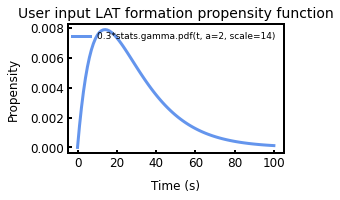

--- kunbind  0.11

~~~ kunbind = 0.11 / s, ligand density = 0.700 / um2

P_act(n=1): 1.0

   kunbind  kbind  ligand_density  prob_activate n_cell
0     0.11   0.91             0.7            1.0      1



In [ ]:
run(
    # kunbind_list = [0.11],
    # ligand_densities = [0.5],
    plot_lat_propensity = True,
    lat_formation_propensity_fn_str = '0.3*stats.gamma.pdf(t, a=2, scale=14)',
    # plot_time_traces = True,
    )

### *Reason for mimicking the propensity function with a gamma function:*

McAffee et al. bioRxiv (2021)
is a good match with the gamma distribution pdf of alpha=2, theta=14. \\

<img src="https://i.imgur.com/gLkLK7q.png">

> <img src="https://i.imgur.com/4Y5g9V5.png">


&nbsp;

Overlay:

> <img src="https://i.imgur.com/IsU4vDa.png" width="400">


